## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import random
import shutil
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## Data Preparation

### Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip -d intel_dataset

seg_train = "intel_dataset/seg_train/seg_train"
seg_test = "intel_dataset/seg_test/seg_test"
seg_pred = "intel_dataset/seg_pred/seg_pred"

merged_dir = "intel_merged"
os.makedirs(merged_dir, exist_ok=True)

for src_dir in [seg_train, seg_test, seg_pred]:
    for label in os.listdir(src_dir):
        label_dir = os.path.join(src_dir, label)
        if os.path.isdir(label_dir):
            target_dir = os.path.join(merged_dir, label)
            os.makedirs(target_dir, exist_ok=True)
            for img in os.listdir(label_dir):
                shutil.copy(os.path.join(label_dir, img), target_dir)

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 334M/346M [00:01<00:00, 206MB/s]
100% 346M/346M [00:01<00:00, 226MB/s]


### Data Preprocessing

#### Split Dataset

In [ ]:
def split_dataset(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15):

    os.makedirs(output_path, exist_ok=True)
    for label in os.listdir(base_path):
        label_dir = os.path.join(base_path, label)
        if not os.path.isdir(label_dir):
            continue

        files = glob.glob(os.path.join(label_dir, "*"))
        if len(files) == 0:
            continue

        train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_size / (val_size + test_size), random_state=42)

        for subset, subset_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
            subset_dir = os.path.join(output_path, subset, label)
            os.makedirs(subset_dir, exist_ok=True)

            for f in subset_files:
                shutil.copy(f, subset_dir)

        print(f"{label}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

split_dataset("intel_merged", "intel_split")

def count_images_in_split(base_path):
    for subset in ["train", "val", "test"]:
        subset_dir = os.path.join(base_path, subset)
        total = 0
        print(f"\n {subset.upper()}:")
        for label in os.listdir(subset_dir):
            count = len(os.listdir(os.path.join(subset_dir, label)))
            total += count
            print(f"  {label:<10}: {count}")
        print(f"  Total images: {total}")

count_images_in_split("intel_split")


buildings: 1839 train, 394 val, 395 test
glacier: 2069 train, 444 val, 444 test
street: 2018 train, 432 val, 433 test
sea: 1948 train, 418 val, 418 test
forest: 1921 train, 412 val, 412 test
mountain: 2125 train, 456 val, 456 test

 TRAIN:
  buildings : 1839
  glacier   : 2069
  street    : 2018
  sea       : 1948
  forest    : 1921
  mountain  : 2125
  Total images: 11920

 VAL:
  buildings : 394
  glacier   : 444
  street    : 432
  sea       : 418
  forest    : 412
  mountain  : 456
  Total images: 2556

 TEST:
  buildings : 395
  glacier   : 444
  street    : 433
  sea       : 418
  forest    : 412
  mountain  : 456
  Total images: 2558


## Modelling

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    'intel_split/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen_val_test.flow_from_directory(
    'intel_split/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen_val_test.flow_from_directory(
    'intel_split/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Found 11920 images belonging to 6 classes.
Found 2556 images belonging to 6 classes.
Found 2558 images belonging to 6 classes.
Epoch 1/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1474s 4s/step - accuracy: 0.5034 - loss: 1.2286 - val_accuracy: 0.6064 - val_loss: 0.9628
Epoch 2/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1458s 4s/step - accuracy: 0.6846 - loss: 0.8237 - val_accuracy: 0.7183 - val_loss: 0.7710
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1444s 4s/step - accuracy: 0.7440 - loss: 0.6891 - val_accuracy: 0.8067 - val_loss: 0.5398
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1450s 4s/step - accuracy: 0.7817 - loss: 0.5904 - val_accuracy: 0.8243 - val_loss: 0.5059
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1447s 4s/step - accuracy: 0.8088 - loss: 0.5248 - val_accuracy: 0.8228 - val_loss: 0.5119
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1444s 4s/step - accuracy: 0.8212 - loss: 0.4944 - val_accuracy: 0.8009 - val_loss: 0.5500
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 1448s 4s/step - accuracy: 0.8303 - loss: 0.4662 - val

## Evaluasi dan Visualisasi

80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8666 - loss: 0.4174

Test Accuracy: 86.40%
Test Loss: 0.4088

Ringkasan Performa:
Train Accuracy: 89.61%
Validation Accuracy: 87.56%
Test Accuracy: 86.40%


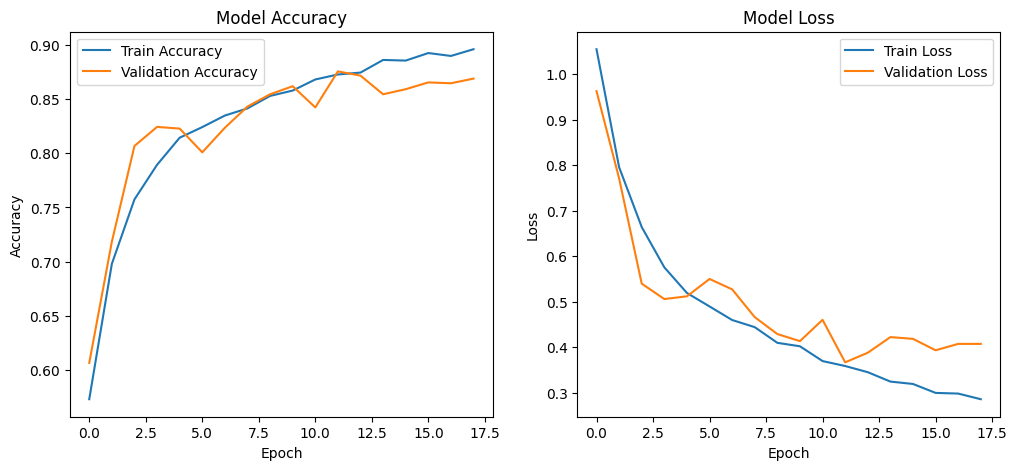

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

print("\nRingkasan Performa:")
print(f"Train Accuracy: {max(history.history['accuracy'])*100:.2f}%")
print(f"Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [ ]:
os.makedirs("submission/saved_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/tfjs_model", exist_ok=True)

model.export("submission/saved_model")

converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

with open("submission/tflite/label.txt", "w") as f:
    for label in train_gen.class_indices.keys():
        f.write(label + "\n")

tfjs.converters.save_keras_model(model, "submission/tfjs_model")

print("\nSemua format model berhasil disimpan ke folder 'submission/'!")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133123752303440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752304976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752306128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752305168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752306512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752306320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752306896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752305552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133123752307088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13312

failed to lookup keras version from the file,
    this is likely a weight only file

Semua format model berhasil disimpan ke folder 'submission/'!


## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Model memprediksi gambar ini sebagai: **buildings**


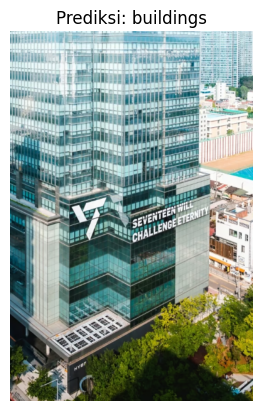

In [ ]:
img_path = "svt build.jpg"

img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

labels = list(train_gen.class_indices.keys())
print(f"Model memprediksi gambar ini sebagai: **{labels[pred_class]}**")

plt.imshow(image.load_img(img_path))
plt.title(f"Prediksi: {labels[pred_class]}")
plt.axis('off')
plt.show()